## Data Loading
First leg of the journey (10,000 points)

In [1]:
import pandas as pd

telemetry = pd.read_csv('./telemetry_cleaned.csv')

X = telemetry[['Easting', 'Northing', 'WaterDepth']].head(10000) # 10,000
# X = telemetry[['Easting', 'Northing', 'WaterDepth', 'DateTime']].head(10000) # 10,000
# X = telemetry.head(10619) # 10,000
# X = X[X['WaterDepth'] >= 30]
# X = X[X['WaterDepth'] <= 65]

### Plot Helpers

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot2d(data):
	data.plot(kind='scatter', x='Easting', y='Northing', color='#1F77B4')

def plot3d(data, title):
	fig = plt.figure()
	ax = fig.add_subplot(projection='3d')
	ax.scatter(data['Easting'], data['Northing'], data['WaterDepth'])
	ax.set_xlabel('Easting')
	ax.set_ylabel('Northing')
	ax.set_label
	ax.set_zlabel('WaterDepth')
	ax.set_title(title)
	plt.show()

def plot_clusters(db, show_noise=True):
	unique_labels = set(db.labels_)
	core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
	core_samples_mask[db.core_sample_indices_] = True

	colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

	for k, color in zip(unique_labels, colors):
		if k == -1 and not show_noise:
			# Black used for noise
			color = [0, 0, 0, 1]
			continue

		class_member_mask = db.labels_ == k

		core_samples = X[class_member_mask & core_samples_mask]

		plt.plot(
			core_samples['Easting'],
			core_samples['Northing'],
			"o",
			markerfacecolor=tuple(color),
			markeredgecolor='k',
			markersize=10,
		)

		non_core_samples = X[class_member_mask & ~core_samples_mask]
		plt.plot(
			non_core_samples['Easting'],
			non_core_samples['Northing'],
			"o",
			markerfacecolor=tuple(color),
			markeredgecolor='k',
			markersize=3,
		)

	plt.title(f'Estimated clusters: {len(unique_labels)-1}')
	plt.show()

### Pre-Clustering Plots

In [ ]:
plot2d(X)

In [ ]:
plot3d(X, 'Leg 1 Pre-DBSCAN')

## DBSCAN Clustering

Using eps=0.3 and min_samples=10

In [10]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

epsilon = 0.15
# epsilon = 1 + (max(telemetry['DateTime']) / min(telemetry['DateTime']))

# epsilon = 1 - (avg_E + avg_N)

avg_e = sum(telemetry['Easting']) / len(telemetry['Easting'])
avg_n = sum(telemetry['Easting']) / len(telemetry['Northing'])
avg_w = sum(telemetry['Easting']) / len(telemetry['WaterDepth'])

max_e = max(telemetry[telemetry['Easting'] < 1]['Easting'])
max_n = max(telemetry[telemetry['Northing'] < 1]['Northing'])
max_w = max(telemetry[telemetry['WaterDepth'] < 1]['WaterDepth'])

e = avg_e / max_e
n = avg_n / max_n
w = avg_w / max_w

epsilon = abs(1 - (e + n + w))
print(epsilon)

db = DBSCAN(eps=epsilon, min_samples=20).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

0.2953844347168384
Estimated number of clusters: 6
Estimated number of noise points: 99


## Cluster Evaluation Metrics

### Silhouette Coefficient
The silhouette coefficient measures the quality of the model by the distance significance between clusters.

It uses the following formula:
$$s = \frac{b-a}{\max{(a,b)}}$$

Where $a$ is the mean distance between a sample and all other points within the *same* cluster, and $b$ is the mean distance between a sample and all other points in the *next nearest* cluster. It outputs a score in the range of -1 to 1, where -1 indicated incorrect clustering and 1 indicates highly dense clustering. A score of 0 indicates an overlap in clusters.

Source: Adapted from [Quick Guide to Evaluation Metrics for Supervised and Unsupervised Machine Learning](https://www.analyticsvidhya.com/blog/2020/10/quick-guide-to-evaluation-metrics-for-supervised-and-unsupervised-machine-learning/) § Clustering Performance Evaluation Metrics

### Implementation
Scikit learn provides a silhouette_score method in its metrics module:

In [11]:
print(f'Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}')

Silhouette Coefficient: 0.508


### Davies-Bouldin Score


In [12]:
print(f'Silhouette Coefficient: {metrics.davies_bouldin_score(X, labels):.3f}')

Silhouette Coefficient: 0.720


## Removing Clusters
First, let's map the labels to each row in the dataset.

In [13]:
X['label'] = labels
X.head(5)

,Easting,Northing,WaterDepth,label
0,0.158187,0.410159,92.93,-1
1,0.158187,0.410159,5.86,-1
2,0.534407,0.535898,5.86,-1
3,0.534311,0.535924,6.33,-1
4,0.533734,0.536254,7.02,-1


Then we can remove the rows labeled as noise, denoted by a value of -1.

In [14]:
denoised = X[X['label'] != -1]
denoised['label'].unique()

array([0, 1, 3, 2, 4, 5], dtype=int64)

Clusters (with noise)

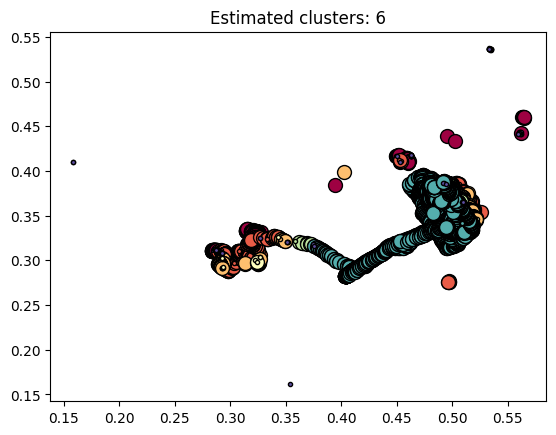

In [15]:
plot_clusters(db)

Clusters (without noise)

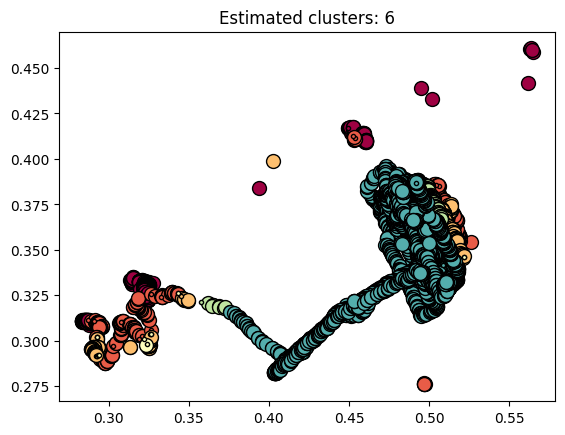

In [16]:
plot_clusters(db, False)